# Introduction

This Jupyter notebook example demonstrates how to run a simple Sesam Core Fatigue screening check  on a floating OWT model made in GeniE, exposed to time-dependent wave loads coming from a Sima coupled analysis results via direct load generation in Wasim, using OneWorkflow locally. 
The start and stop time of the Wasim_solve are read from an Excel spreadsheet for each load case. Furthermore, the start of load mapping in Wasim_stru can be delayed by adding number of time steps to omit.

<img src="OC4_model.png" alt="image" width="30%" height="auto">

This notebook example is organized in chapters for setup, prepare input and run Sesam analysis, download results and post-processing. Each chapter contains several cells with markdown, Python code or output. To view the content of each cell, expand the chapter title, then click the short vertical grey or blue bar on the far left to expand. Click again to compress.

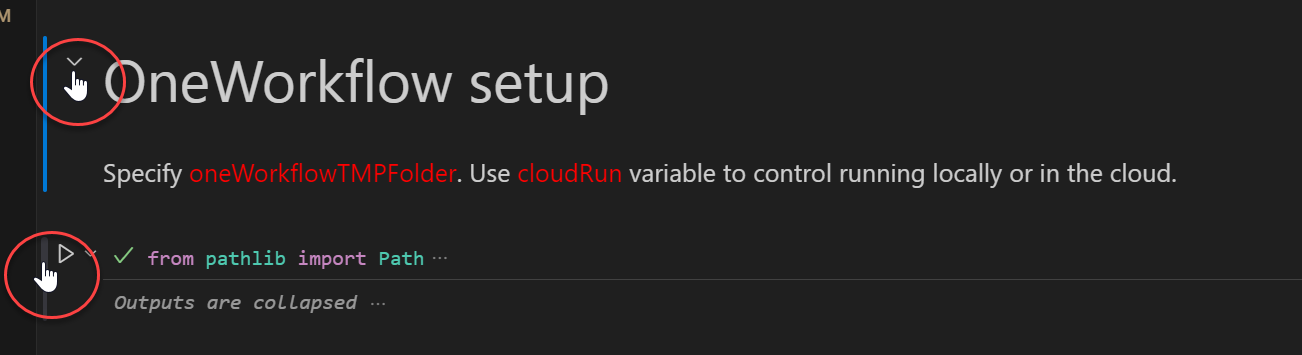

# OneWorkflow setup

- Specify <font color='red'>root_folder</font>
- Specify <font color='red'>workspacePath</font>
- Specify <font color='red'>workspaceId</font>
- Use <font color='red'>cloudRun</font> variable to control running locally or in the cloud. (**note**: Cloud support coming soon!)

In [ ]:
from pathlib import Path
import os, sys
from dnv.oneworkflow.utils.workunit_extension import *
from dnv.oneworkflow.utils import *
# local workspace, all results will be put here after local or cloud runs
# location of common files for all analysis, has to be below workspacePath and in the folder names CommonFiles
sys.path.append("../PythonModules")
root_folder = os.getcwd()
workspacePath = str(Path(root_folder, 'Workspace'))
workspaceId = "WasimSesamCoreExample"
cloudRun = False
skip_fatigue = False # if true, run only sestra not sesam core

#If running locally the code below will also start the local workflow host.
workflow_client = one_workflow_client(workspace_id = workspaceId, workspace_path = workspacePath, cloud_run = cloudRun, inplace_execution=True)
local__result_path = Path(workspacePath, workflow_client.results_directory)


# Read Excel input, update template parameters in .inp files, run Wasim and Sesam Core

Files and file locations:
- Excel file with load case names and start/stop/time step info
    - In Workspace folder, file name defined in the cell below using variable <font color='red'>wasim_input_file</font>
- Sima coupled analysis results files in LoadCases\LC000X (as specified in Excel) 
- All other model and input, including template files

In [ ]:
import pandas as pd
import os
from dnv.sesam.commands import *
from dnv.oneworkflow import *
import shutil
import json
from WasimTaskCreator import *
parameter_input_file = "parameter_input.xlsx" #KBLU FIX THIS
parameters_from_excel = pd.read_excel(os.path.join(workspacePath, parameter_input_file), index_col=0)

#Some hardcoded template parameters (not read from Excel)
topsuper = 1
try:
    os.chdir(os.path.join(workspacePath,"LoadCases"))
except:
    print("LoadCases folder not found")
#Recognize the following column titles in Excel spreadsheet and map them to the correct input parameters given in Wasim template files
parameter_mapping = {'TimeStep': "timestep", "StartTime": "start_solve", "EndTime": "stop_solve", "NSteps": "nsteps"}
commands_info = []
local__result_path = Path(workspacePath, workflow_client.results_directory)
print(local__result_path)
if os.path.isdir(local__result_path):
   try:
       shutil.rmtree(local__result_path) 
   except:
       print("Could not delete the results folder")
shutil.copytree(os.path.join(workspacePath,"Input"),os.path.join(workspacePath),dirs_exist_ok=True)
display(parameters_from_excel)
for casename, case in parameters_from_excel.iterrows():
    casedict = case.to_dict()
    input_parameters = {}
    # find the values from the Excel sheet for give load case
    for key, value in case.items():
        input_parameters[parameter_mapping[key]] = str(value)
    input_parameters['stop_stru'] = input_parameters['stop_solve']
    input_parameters['mor_topsel'] = topsuper
    
    # Possibility to delay start of load transfer with a number of time steps, add to the floating numbers
    input_parameters['start_stru'] = float(input_parameters['start_solve'])+ 1. * float(input_parameters['timestep'])
    
    input_parameters['FATIGUESTART'] = float(input_parameters['start_solve'])
    input_parameters['FATIGUEEND'] = float(input_parameters['stop_solve'])
   
    print("The following parameters are used for load case: " + casename)
    print(json.dumps(input_parameters, indent=4, sort_keys=True))
    tasks = WasimTaskCreator().CreateTasks(input_parameters)
    if skip_fatigue:
        sestra_command = SestraCommand()
        sestra_command.arguments = "/dsf"
        tasks.append(sestra_command)
    else:
        #Update Sesam Core .jnl file
        sesam_core_template_command = CreateInputFileFromFileTemplateCommand(
            template_input_file  = "SesamCore_screening_template.jnl",
            input_filename  = "SesamCore_screening.jnl",
            parameters= input_parameters
            )
        tasks.append(sesam_core_template_command)
        score_command = SesamCoreCommand(command = "fatigue",input_file_name= "input.json", options = "-s -v")
        tasks.append(score_command)
    commands_info.append(CommandInfo(commands=tasks,load_case_foldername=casename))
    
print("Running commands in parallel")
await run_managed_commands_in_parallel_async(
            client=workflow_client,
            commands_info=commands_info,
            log_job=False,
            files_to_upload_from_client_to_blob=FileTransferOptions(max_size="11124MB",patterns=["**/sim*.*","CommonFiles/*.*","**/*.json","**/*.inp","**/*.ssg","**/*.FEM","**/*.jnl"]),
            files_to_download_from_blob_to_client=FileTransferOptions(max_size="11124MB",patterns=["**/sestra.inp", "**/wasim_setup.inp", "**/wasim_solve.inp", "**/wasim_snapshots.inp", "**/wasim_stru.inp", "**/*.csv", "**/*.lis", "**/*.mlg", "**/*.sin", "**/*.FEM","**/*.JNL"]),
            enable_common_files_copy_to_load_cases=True
)


## Check if analysis is successful

In [ ]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
current_date = now.strftime("%d/%m/%Y")
print(current_time, current_date)

#Search different log file types for different messages
#Report only not successful log files

local__result_path = Path(workspacePath, workflow_client.results_directory)
os.chdir(local__result_path)
import analysisStatusChecker
analysisStatusChecker.checkWasimStatus()
if skip_fatigue:
    analysisStatusChecker.checkSestraStatus()
else:
    analysisStatusChecker.checkSesamCoreStatus()

# Post-processing
Quality checks, maximum usage factors and criterion etc

### Plot of reaction force from Sestra

In [ ]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
current_date = now.strftime("%d/%m/%Y")
print(current_time, current_date)
 
def format_time(value, _):
    return "{:.1e}".format(value)  # Format the time with two decimal places
for loadcase_folder_name, _ in parameters_from_excel.iterrows():
    result_folder = os.path.join(workspacePath,workflow_client.results_directory, loadcase_folder_name)
    result_path = os.path.join(result_folder, "_reactions_history1.csv")
    reaction_history = pd.read_csv(result_path)
    df = pd.read_csv(result_path, delimiter=';') 
    from matplotlib import pylab as plt
    from matplotlib.ticker import FuncFormatter
    # Set the default font size for all labels

    time = df['Time']
    fx = df['FX']
    fy = df['FY']
    fz = df['FZ']
    mx = df['MX']
    my = df['MY']
    mz = df['MZ']

    # Define a custom formatting function for x-axis values
   

    # Plot a 2D graph
    plt.plot(time, fz, marker='o', label='FZ')

    # Add labels and title
    plt.xlabel('Result case id', fontsize=10)
    plt.ylabel('Force', fontsize=10)
    plt.xticks(fontsize=10)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_time))
    plt.yticks(fontsize=10)
    plt.title('Reaction z-force over time-history', fontsize=14)
    plt.legend(fontsize=10)  # Show legend with labels

    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title('Reaction z-force over time-history for loadcase' + loadcase_folder_name, fontsize=14)
            
    # Set x-axis limits
    plt.xlim(min(time), max(time))


    # Show the plot
    plt.show()
    plt.savefig(os.path.join(result_folder,"reaction_forces_plot.png"))